In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import misc
from misc import show_img
import prop

from skimage import io
import geometric_graph
import networkx.drawing as draw
import networkx as nx

In [2]:
class gland_property():
    img = None, False, -1, None, None, None, None, None, None, None

    def __init__(self, _id, _row, _column, _area, _demarcated, _solidity, _eccentricity, _equivalent_diameter, _perimeter, _degree, _strength, _betweenness):
        #identification
        self.id = _id,
        self.row = _row,
        self.column = _column,
        self.demarcated = _demarcated
        #shape measures
        self.area = _area, 
        self.solidity = _solidity,
        self.eccentricity = _eccentricity,
        self.equivalent_diameter = _equivalent_diameter,
        self.perimeter = _perimeter,
        
        #net properties
        self.degree = _degree
        self.strength = _strength
        self.betweenness = _betweenness


In [3]:
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise mkdir_p(mypath)
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

In [4]:
def get_paths(root, display_results=True):
    path_img = root + '/IMG.jpg'
    path_mask = root + '/MASK.jpg'
    path_expert_demarcation = root + '/CA MASK.jpg'
    path_result = root + '/results_radius_' + str(radius)
    mkdir_p(path_result)

    path_gml = path_result + "/graph_" + str(radius) + "r.gml"
    path_graph_png = path_result + "/graph_" + str(radius) + "r.png"
    path_result_txt = path_result + '/glands_properties_' + str(radius) +'r.txt'
    path_gml_props = path_result + "/grafo_glands_properties_" + str(radius) + "r.gml"

    if display_results:
        print(path_img)
        print(path_mask)
        print(path_expert_demarcation)
        print(path_result)
        print(path_gml)
        print(path_graph_png)
        print(path_result_txt)
        print(path_gml_props)
        
    return path_img, path_mask, path_expert_demarcation, path_result, path_gml, path_graph_png, path_result_txt, path_gml_props

In [5]:
def verify_images(path_img, path_mask, path_expert_demarcation, display_results):
    img = io.imread(path_img)

    mask = io.imread(path_mask)
    mask = misc.mask_correction(mask)

    expert_demarcation = io.imread(path_expert_demarcation)
    expert_demarcation = misc.mask_correction(expert_demarcation)

    if not((img.shape[0], img.shape[1]) == mask.shape == expert_demarcation.shape):
        print('Images must have the same size')

    if display_results:
        show_img(255-expert_demarcation, 'Expert Demarcation')
        show_img(img, 'Glands Image')
        show_img(255-mask, 'Glands Mask')
        
    return img, mask, expert_demarcation

In [6]:
def generate_geometric_graph(mask, radius, path_graph_png, path_gml):
    g, points = geometric_graph.network_from_mask(mask, radius)
    nxgraph = misc.igraph_to_nx(g)
    g.vs['pos'] = points.tolist()

    if display_results:
        fig = plt.figure(figsize=(40,15))
        ax = plt.subplot(111, aspect='equal')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        #draw.draw_networkx(nxgraph, points, node_size=5, with_labels=False, edge_alpha=0.1)
        draw.draw_networkx_edges(nxgraph, points, alpha = 0.4)
        draw.draw_networkx_nodes(nxgraph, points, node_size=5, with_labels=False)
        plt.savefig(path_graph_png)

    nxgraph = misc.igraph_to_nx(g)
    nx.write_gml(nxgraph, path_gml)

    return g, points, nxgraph

In [7]:
def generate_glands_properties(mask, shape_props_to_measure, g, nxgraph, display_results):
    shape_props, props = prop.get_shape_props_from_mask(mask, shape_props_to_measure, return_scikit_props=True)

    if(len(shape_props[ : , 0 ]) != g.vcount()):
        print('ALERT! PROPERTIES TABLE MUST HAVE THE SAME NUMBER OF GRAPH VERTICES')
    else:
        print(str(g.vcount()) + ' Glands')

    # Calculate edge weights
    pos_nodes = g.vs["pos"]
    weight_dict = prop.calculate_weight_all(nxgraph, pos_nodes, shape_props, att_idx=0, normalize_pos=True, normalize_att=True)
    weights = list(weight_dict.values())

    nx.set_edge_attributes(nxgraph, weight_dict, 'weight')
    net_props = prop.get_graph_props(nxgraph)

    if display_results:
        misc.plot_graph(nxgraph, pos_nodes, weights, mask, minEdgeWidth, maxEdgeWidth, 'Shape Properties Normalized')
    
    gland_properties  = []
    count = 0

    for idx in range(len(shape_props)):
        position = list(map(int, props[idx].centroid))
        obj = gland_property(_id = count, _row=int(position[0]), _column=int(position[1]), _demarcated=(expert_demarcation[position[0]][position[1]]==255), _area=shape_props[idx][0], _solidity=shape_props[idx][1], _eccentricity=shape_props[idx][2], _equivalent_diameter=shape_props[idx][3], _perimeter=shape_props[idx][4], _degree=net_props[idx][0], _strength=net_props[idx][1], _betweenness=net_props[idx][2])
        gland_properties.append(obj)
        count = count + 1

    if display_results:
        demarcated_quantity_ = [(t.row[0],t.column[0]) for t in gland_properties if t.demarcated == True]
        print('Glands in Demarcated Area: ' + str(len(demarcated_quantity_)))        
        
    return gland_properties

In [8]:
def generate_data(gland_properties, nxgraph, path_result_txt, path_gml_props):
    with open(path_result_txt, 'w') as f:
        f.write('idx, row, column, demarcated, area, solidity, eccentricity, equivalent_diameter, perimeter, degree, strength, betweenness\n')
        for item in gland_properties:
            f.write("%d, %d, %d, %s, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f\n" % (item.id[0], item.row[0], item.column[0], item.demarcated, item.area[0], item.solidity[0], item.eccentricity[0], item.equivalent_diameter[0], item.perimeter[0], item.degree, item.strength, item.betweenness))

    nxgraph_properties = nxgraph = nx.Graph(nxgraph)

    id_dict = {}
    row_dict = {}
    column_dict = {}
    demarcated_dict ={}
    area_dict = {}
    solidity_dict = {}
    eccentricity_dict = {}
    equivalent_diameter_dict = {}
    perimeter_dict = {}
    degree_dict = {}
    strength_dict = {}
    betweenness_dict = {}

    for t in gland_properties:
        id_dict[t.id[0]] = t.id[0]
        row_dict[t.id[0]] = t.row[0]
        column_dict[t.id[0]] = t.column[0]
        demarcated_dict[t.id[0]] = str(t.demarcated)
        area_dict[t.id[0]] = t.area[0]
        solidity_dict[t.id[0]] = t.solidity[0]
        eccentricity_dict[t.id[0]] = t.eccentricity[0]
        equivalent_diameter_dict[t.id[0]] = t.equivalent_diameter[0]
        perimeter_dict[t.id[0]] = t.perimeter[0]
        degree_dict[t.id[0]] = t.degree
        strength_dict[t.id[0]] = t.strength
        betweenness_dict[t.id[0]] = t.betweenness

    nx.set_node_attributes(nxgraph, id_dict, 'idx')
    nx.set_node_attributes(nxgraph, row_dict, 'row')
    nx.set_node_attributes(nxgraph, column_dict, 'column')
    nx.set_node_attributes(nxgraph, demarcated_dict, 'demarcated')
    nx.set_node_attributes(nxgraph, area_dict, 'area')
    nx.set_node_attributes(nxgraph, solidity_dict, 'solidity')
    nx.set_node_attributes(nxgraph, eccentricity_dict, 'eccentricity')
    nx.set_node_attributes(nxgraph, equivalent_diameter_dict, 'diameter')
    nx.set_node_attributes(nxgraph, perimeter_dict, 'perimeter')
    nx.set_node_attributes(nxgraph, degree_dict, 'degree')
    nx.set_node_attributes(nxgraph, strength_dict, 'strength')
    nx.set_node_attributes(nxgraph, betweenness_dict, 'betweenness')

    nx.write_gml(nxgraph_properties, path_gml_props)

In [9]:
#array_radius = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
array_radius = [350]
minEdgeWidth = 3
maxEdgeWidth = 10

display_results = True
root = 'prostate_marked/S07_46186 10X_20151028_59'
#root = 'prostate_marked/3'
shape_props_to_measure = ['area', 'solidity', 'eccentricity', 'equivalent_diameter', 'perimeter']

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (137175380 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


3364 Glands


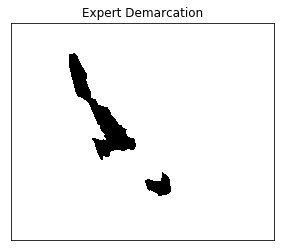

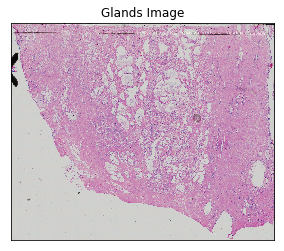

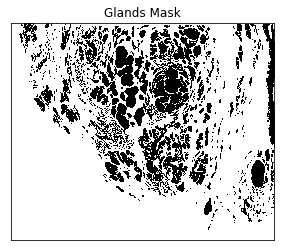

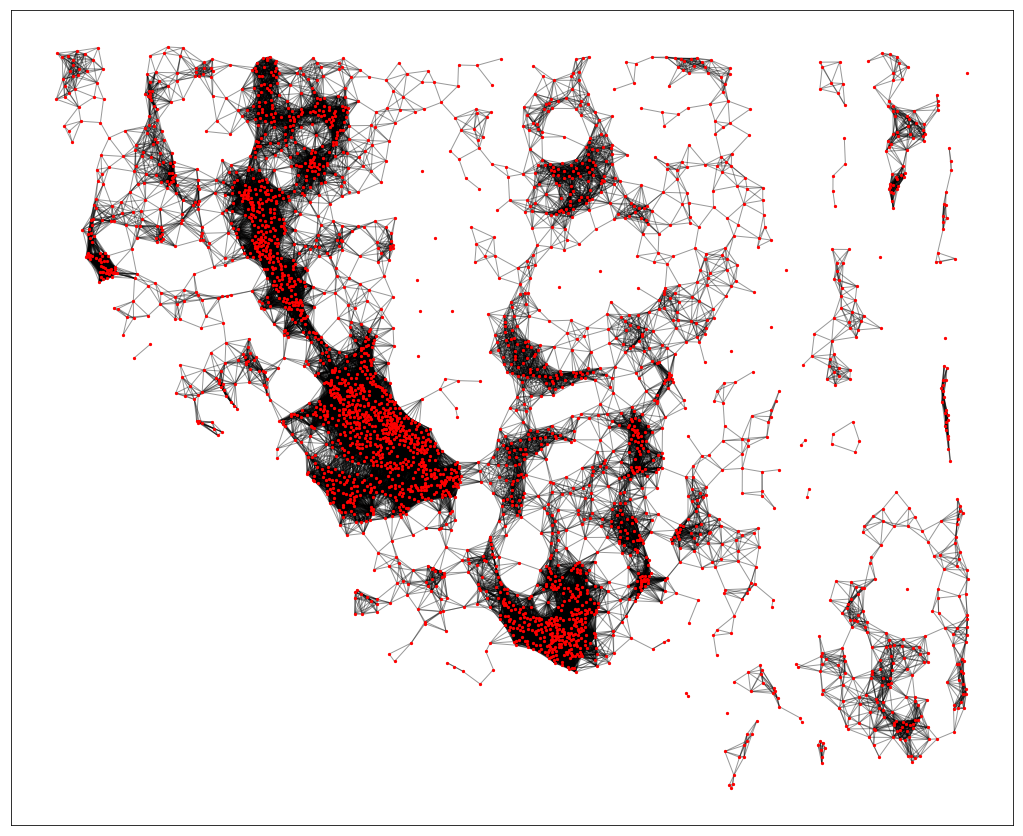

In [10]:
for radius in array_radius:
    path_img, path_mask, path_expert_demarcation, path_result, path_gml, path_graph_png, path_result_txt, path_gml_props = get_paths(root, display_results=False)
    img, mask, expert_demarcation = verify_images(path_img, path_mask, path_expert_demarcation, display_results=True)
    g, points, nxgraph = generate_geometric_graph(mask, radius, path_graph_png, path_gml)

    glands_properties = generate_glands_properties(mask, shape_props_to_measure, g, nxgraph, display_results=False)

    generate_data(glands_properties, nxgraph, path_result_txt, path_gml_props)

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (137175380 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


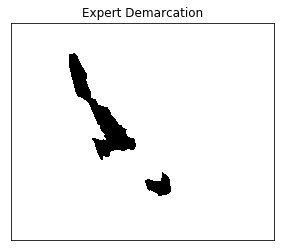

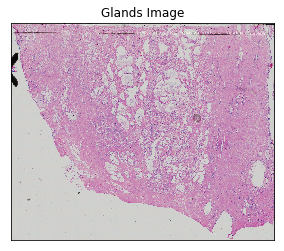

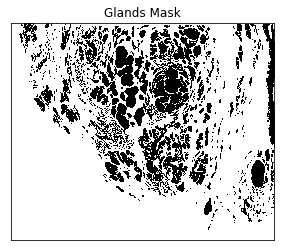

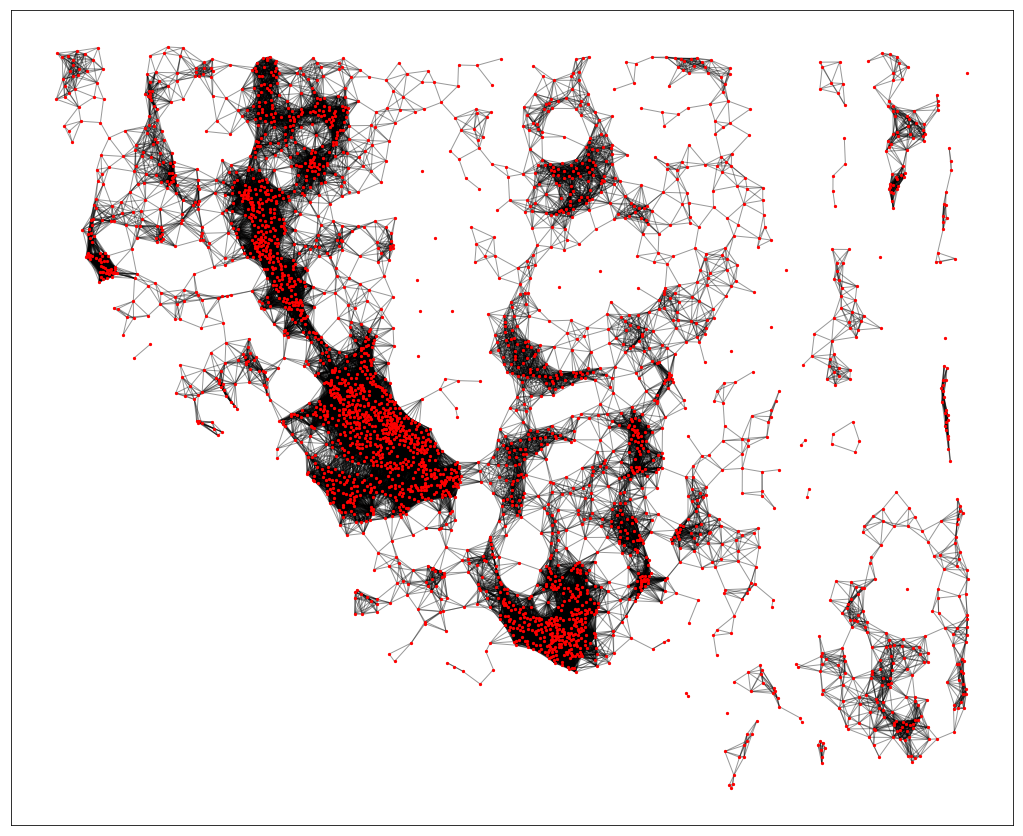

In [11]:
#for radius in array_radius:
radius = 350

path_img, path_mask, path_expert_demarcation, path_result, path_gml, path_graph_png, path_result_txt, path_gml_props = get_paths(root, display_results=False)
img, mask, expert_demarcation = verify_images(path_img, path_mask, path_expert_demarcation, display_results=True)
g, points, nxgraph = generate_geometric_graph(mask, radius, path_graph_png, path_gml)


